In [72]:
import os
import pandas as pd
import numpy as np

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop, SGD
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [3]:
X_topic = []
Y_topic = []

X_path = 'topic_vectors.txt'
Y_path = 'topic_names.txt'

if(os.path.isfile(X_path) and os.path.isfile(Y_path)):
    print('load from .txt file')
    X_topic = np.loadtxt(X_path)
    with open(Y_path, 'r') as f:
        for line in f.readlines():
            Y_topic.append(line.replace('\n',''))
    Y_topic = np.array(Y_topic)

load from .txt file


In [4]:
name2vector = {}
for i in range(X_topic.shape[0]):
    name2vector[str(Y_topic[i])] = X_topic[i]

In [5]:
siamese_data = pd.read_csv('siamese_data.csv')

In [6]:
siamese_data.shape

(60105, 3)

In [7]:
siamese_data.head()

,name1,name2,target
0,Трепетание предсердий,Сочетанные пороки сердца,1
1,Синдром WPW,Трепетание предсердий,1
2,Сердечная астма,Гемоперикард,1
3,Гемоперикард,Постинфарктная стенокардия,1
4,Общий артериальный ствол,Артериальная гипертензия,1


## Data

In [8]:
emb_size = 250

In [9]:
X = np.zeros((siamese_data.shape[0], 2, emb_size))
y = np.array(siamese_data['target'].values)

In [10]:
for d, i in siamese_data.iterrows():
    X[d, 0, :] = name2vector[i[0]]
    X[d, 1, :] = name2vector[i[1]]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36063, 2, 250), (24042, 2, 250), (36063,), (24042,))

In [13]:
np.bincount(y_train), np.bincount(y_test)

(array([33924,  2139]), array([22616,  1426]))

## Model

In [14]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [15]:
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Dense(176, activation='relu')(input)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

In [16]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [17]:
input_shape = (250,)
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [18]:
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

In [19]:
history = model.fit([X_train[:, 0, :], X_train[:, 1, :]], y_train,
          batch_size=128,
          epochs=50,
          validation_data=([X_test[:, 0, :], X_test[:, 1, :]], y_test))

Train on 36063 samples, validate on 24042 samples
Epoch 1/50
36063/36063 [==============================] - 2s - loss: 0.0493 - accuracy: 0.9420 - val_loss: 0.0400 - val_accuracy: 0.9517
Epoch 2/50
36063/36063 [==============================] - 2s - loss: 0.0389 - accuracy: 0.9472 - val_loss: 0.0337 - val_accuracy: 0.9568
Epoch 3/50
36063/36063 [==============================] - 2s - loss: 0.0338 - accuracy: 0.9531 - val_loss: 0.0364 - val_accuracy: 0.9634
Epoch 4/50
36063/36063 [==============================] - 2s - loss: 0.0301 - accuracy: 0.9585 - val_loss: 0.0312 - val_accuracy: 0.9668
Epoch 5/50
36063/36063 [==============================] - 2s - loss: 0.0275 - accuracy: 0.9627 - val_loss: 0.0260 - val_accuracy: 0.9639
Epoch 6/50
36063/36063 [==============================] - 2s - loss: 0.0254 - accuracy: 0.9665 - val_loss: 0.0267 - val_accuracy: 0.9713
Epoch 7/50
36063/36063 [==============================] - 3s - loss: 0.0238 - accuracy: 0.9699 - val_loss: 0.0235 - val_accuracy

In [20]:
y_pred = model.predict([X_test[:, 0, :], X_test[:, 1, :]])

In [21]:
y_pred_np = y_pred.ravel() < 0.5

In [22]:
print(classification_report(y_test, y_pred_np))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     22616
          1       0.97      0.77      0.86      1426

avg / total       0.98      0.99      0.98     24042



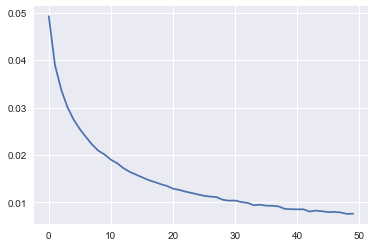

In [23]:
plt.plot(range(len(history.history['loss'])), history.history['loss'])
plt.show()

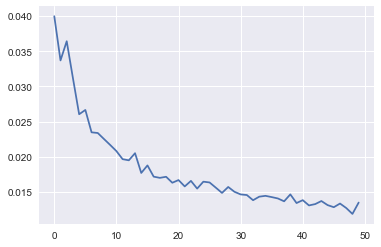

In [24]:
plt.plot(range(len(history.history['loss'])), history.history['val_loss'])
plt.show()

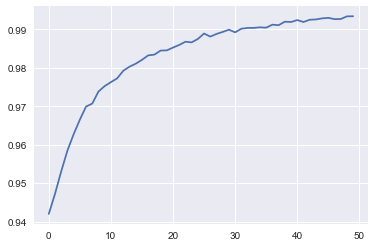

In [25]:
plt.plot(range(len(history.history['loss'])), history.history['accuracy'])
plt.show()

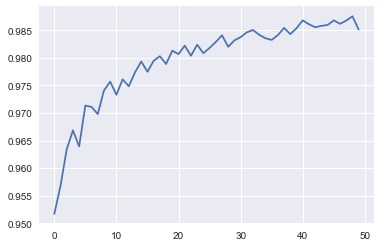

In [26]:
plt.plot(range(len(history.history['loss'])), history.history['val_accuracy'])
plt.show()

## Test

In [27]:
Y_topic

array(['Hallux valgus', 'HELLP-синдром', 'Абдоминальная мигрень', ...,
       'Ячмень на веке', 'Ячмень у ребенка', 'Ящур'], dtype='<U59')

In [28]:
test = np.zeros((1, 2, emb_size))

In [29]:
a = name2vector['Инородное тело уретры']
b = name2vector['Аортальный стеноз']
test[0, 0, :] = a
test[0, 1, :] = b

In [81]:
model.predict([test[:, 0, :], test[:, 1, :]])

array([[1.3642801]], dtype=float32)

In [31]:
siamese_data.sample(5)

,name1,name2,target
30698,Эпидуральная гематома,Руминационное расстройство,0
58883,Синдром Геллера,Острый панкреатит,0
25215,Острая пневмония,Аллергия на цитрусовые,0
23554,Эхинококкоз легких,Полное предлежание плаценты,0
29106,Окклюзия сонных артерий,Менингиома зрительного нерва,0


In [32]:
def getClosestDis(dis_name, model, Y_topic, emb_size, cnt):
    test = np.zeros((len(Y_topic), 2, emb_size))
    for ind, i in enumerate(Y_topic):
        test[ind, 0, :] = name2vector[dis_name]
        test[ind, 1, :] = name2vector[i]
        
    score = model.predict([test[:, 0, :], test[:, 1, :]]).ravel()
    indexs = np.argsort(np.array(score))
    
    res = [(Y_topic[i]) for i in indexs[1:cnt]]
    return res

In [77]:
getClosestDis('Острая пневмония', model, Y_topic, emb_size, 10)

['Стафилококковая пневмония',
 'Бронхит',
 'Острый обструктивный бронхит',
 'Туберкулез легких',
 'Пневмосклероз',
 'Обструктивный бронхит',
 'Аспирационная пневмония',
 'Затяжная пневмония',
 'Бронхит курильщика']

In [34]:
def cos_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

In [35]:
def getSim(vec, cnt):
    sim = []
    for i in X_topic:
        sim.append(cos_sim(vec, i))
    indexs = np.argsort(np.array(sim))
    
    res = [(Y_topic[i]) for i in indexs[-cnt:]]
    return res

In [78]:
getSim(name2vector['Острая пневмония'], 10)

['Стрептококковая пневмония',
 'Пневмококковая пневмония',
 'Вирусная пневмония',
 'Затяжная пневмония',
 'Очаговая пневмония',
 'Микоплазменная пневмония',
 'Бактериальная пневмония',
 'Долевая пневмония',
 'Пневмония',
 'Острая пневмония']

In [85]:
def getEmbedding(model, input):
    get_outputs = K.function([[model.layers[0].input, model.layers[1].input], K.learning_phase()], 
                             [model.layers[2].layers[-1].output])
    ker_output = get_outputs([input, False])[0]
    return ker_output

In [90]:
# getEmbedding(model, [test[:, 0, :], test[:, 1, :]])